## LSTM

This notebook is meant to set up an LSTM for predicting load.

In [861]:
#!/usr/bin/env python
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [862]:
data = pd.read_csv("./data_oct20.csv", parse_dates = ["date"])
data = data.iloc[::10]
data.head(2)

,L2_react,L2,L,L_react,NS4949_export,L2_active_import,PV,Wind_speed,Temperature,Global_irradiance,Plane_irradiance,Module_temp,Bat_current,Bat_energy,Battery_SOC,Battery_voltage,Battery_charge,Battery_discharge,date,L1
0,-1.672253,8.917166,105.823796,-1.330095,103.75,7.500,0.003709,5.0,1.885714,0.017964,0.018072,0.000171,-0.181818,762.249603,69.649998,751.549988,0.000042,0.000031,2020-10-01 01:00:00,96.906629
10,-1.528216,6.749649,99.311711,1.809572,115.00,5.625,0.037092,3.0,13.221428,0.179641,0.180723,0.001712,-0.714286,761.702393,69.599998,751.555542,0.000416,0.000313,2020-10-01 01:10:00,92.562062


In [863]:
data.shape

(4464, 20)

In [864]:
N = 50
cleaned = np.convolve(data["L"], np.ones(N)/N, mode='same')

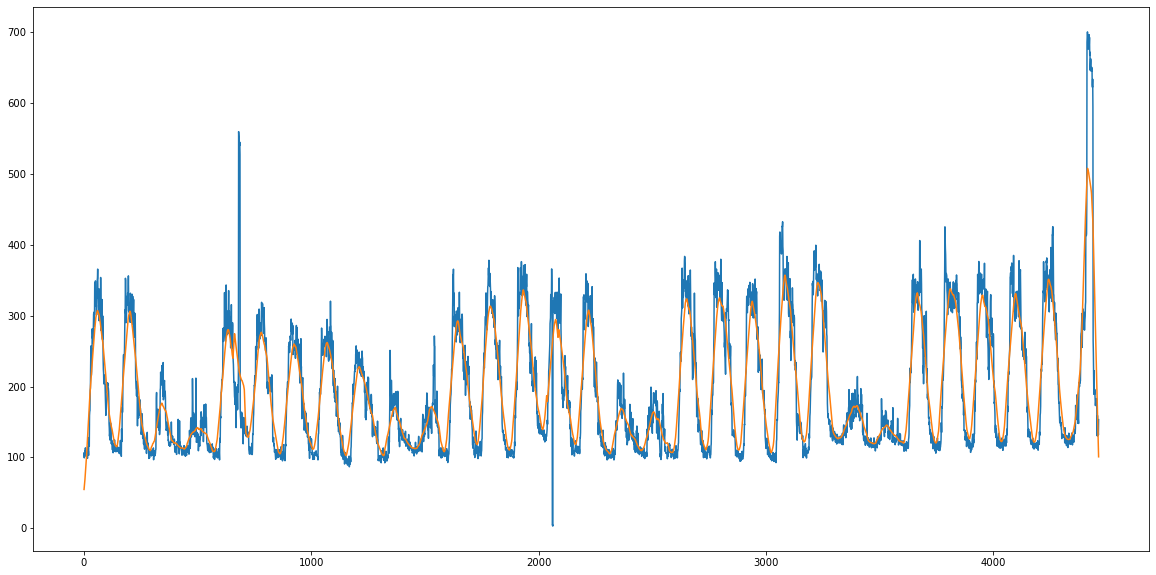

In [865]:
plt.figure(figsize = (20, 10))
plt.plot(range(data.shape[0]), data.L)
plt.plot(range(data.shape[0]), cleaned)

In [866]:
data["time"]=data.date.dt.hour + data.date.dt.minute/60

In [867]:
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    """
    Transforms data to dataframe for training
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [("var{}(t-{})".format(j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [("var{}(t)".format(j+1)) for j in range(n_vars)]
        else:
            names += [("var{}(t+{})".format(j+1, i)) for j in range(n_vars)]
            
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg
    

In [868]:
vars_ = ["PV", "Global_irradiance", "Temperature", "time"]
n_vars = len(vars_)
n_in = 24
n_out = 12

df = data.filter(vars_)
    
if True:
    N = 10
    for column in df.columns:
        df[column] = np.convolve(df[column],np.ones(N)/N, mode='same')
df = df.values

if True:
    scaler = MinMaxScaler(feature_range=(0,1))
    df = scaler.fit_transform(df)

values = series_to_supervised(df, n_in, n_out).values
n_train = 24*144
train = values[:n_train, :]
test = values[n_train:, :]

train_X, train_Y = train[:,:n_vars*n_in], train[:, -n_vars*n_out:]
test_X, test_Y = test[:,:n_vars*n_in], test[:, -n_vars*n_out:]

train_X = train_X.reshape((train_X.shape[0], n_in, n_vars))
test_X = test_X.reshape((test_X.shape[0], n_in, n_vars))

train_X.shape, train_Y.shape

((3456, 24, 4), (3456, 48))

In [869]:

model = k.Sequential()
model.add(k.layers.LSTM(60, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(k.layers.Dense(train_Y.shape[1]))

opt = k.optimizers.Adam(learning_rate= 0.1)
earlystopping = k.callbacks.EarlyStopping(patience= 30, restore_best_weights=True, verbose = True)
reduceLR = k.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001, verbose = True)

model.compile(loss="mse", optimizer=opt)


print(model.summary())
history = model.fit(train_X, train_Y, epochs = 200, batch_size = 64, callbacks = [earlystopping, reduceLR], validation_data = (test_X, test_Y), verbose = 2, shuffle=False)

Model: "sequential_123"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_124 (LSTM)              (None, 60)                15600     
_________________________________________________________________
dense_122 (Dense)            (None, 48)                2928      
Total params: 18,528
Trainable params: 18,528
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
54/54 - 2s - loss: 0.4135 - val_loss: 0.0323
Epoch 2/200
54/54 - 0s - loss: 0.0286 - val_loss: 0.0215
Epoch 3/200
54/54 - 0s - loss: 0.0209 - val_loss: 0.0180
Epoch 4/200
54/54 - 0s - loss: 0.0203 - val_loss: 0.0186
Epoch 5/200
54/54 - 0s - loss: 0.0200 - val_loss: 0.0170
Epoch 6/200
54/54 - 0s - loss: 0.0187 - val_loss: 0.0165
Epoch 7/200
54/54 - 0s - loss: 0.0182 - val_loss: 0.0162
Epoch 8/200
54/54 - 0s - loss: 0.0177 - val_loss: 0.0158
Epoch 9/200
54/54 - 0s - loss: 0.0172 - val_loss:

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'][1:], label='train')
plt.plot(history.history['val_loss'][1:], label='test')
plt.legend()
plt.show()

In [ ]:
test_X[0].shape

In [ ]:
yhat = model.predict(test_X)

In [774]:
def manual_inverter(yhat, scaler):
    y_max = scaler.data_max_[0]
    y_min = scaler.min_[0]

    return  yhat * (y_max-y_min) - y_min 

yhat = manual_inverter(yhat[:,::n_vars], scaler)

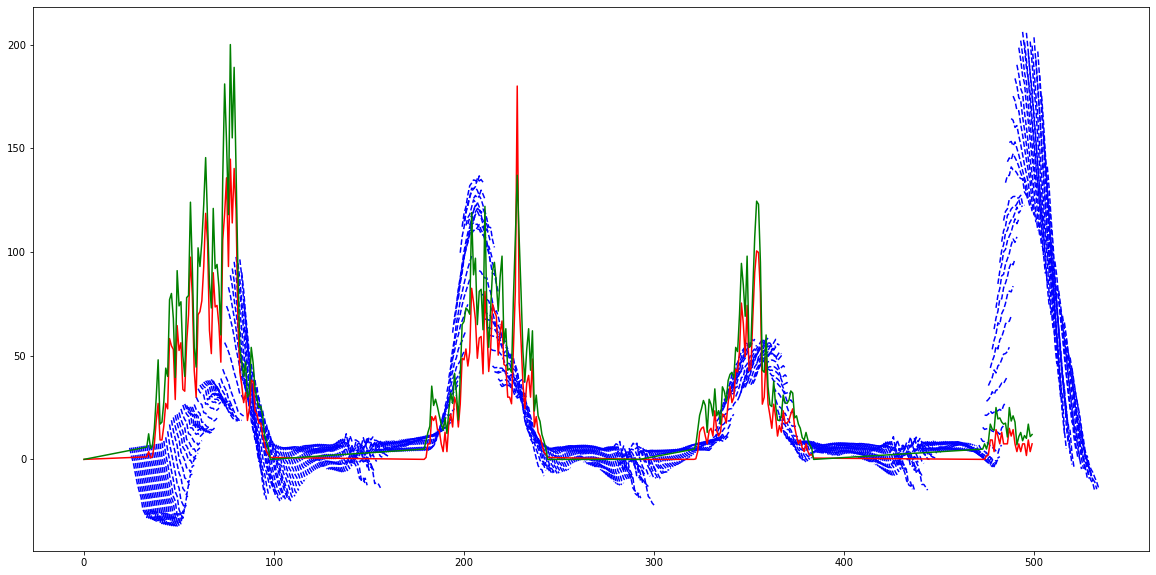

In [780]:
plot_X = manual_inverter(test_X[:,:,::4].reshape((test_X.shape[0], n_in)), scaler)

num_steps = np.min([plot_X.shape[0], 500])
plt.figure(figsize = (20,10))
for step in range(num_steps):
    #plt.plot(range(step, step + plot_X.shape[1]), plot_X[step], color = "Red")
    #plt.plot(range(step + plot_X.shape[1], step + plot_X.shape[1] + n_out), yhat[step],color = "blue",linestyle="dashed")
    if step % 1== 0:
        plt.plot(range(step + plot_X.shape[1], step + plot_X.shape[1] + n_out), yhat[step],color = "blue",linestyle="dashed")
    if step > num_steps:
        break
        
        
plt.plot(range(num_steps), data["PV"].iloc[0:num_steps], color = "red")
plt.plot(range(num_steps), data["Global_irradiance"].iloc[0:num_steps], color = "green")
plt.show()

In [2]:
from lstm import LSTM

lstm = LSTM("./data_oct20.csv", "PV", ["Global_irradiance","Temperature", "time"], 6, 6, lstm_nodes= 30)

Prepared data with the following variables: ['PV', 'Global_irradiance', 'Temperature', 'time']
Shape of train set (35712, 6, 4), shape of test set (8917, 6, 4).

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30)                4200      
_________________________________________________________________
dense_1 (Dense)              (None, 24)                744       
Total params: 4,944
Trainable params: 4,944
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/50
558/558 - 3s - loss: 0.0594 - val_loss: 0.0343
Epoch 2/50
558/558 - 1s - loss: 0.0232 - val_loss: 0.0241
Epoch 3/50
558/558 - 1s - loss: 0.0211 - val_loss: 0.0594
Epoch 4/50
558/558 - 1s - loss: 0.0517 - val_loss: 0.0111
Epoch 5/50
558/558 - 1s - loss: 0.0244 - val_loss: 0.0116
Epoch 6/50
558/558 - 1s - loss: 0.0634 - val_loss: 0.0634
Epoch 7/50
558/558 - 1s - loss: 0.0277 - val_loss: 0.0481
Epoch 8/50
558/558 - 1s - loss: 0.0352 - val_loss: 0.0335
Epoch 9/50
558/558 - 1s - loss: 0.0462 - val_loss: 0.0344

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.05000000074505806.
Epoch 10/50
558/558 - 1s - loss: 0.0109 - val_loss: 0.0329
Epoch 11/50
558/558 - 1s - loss: 0.0103 - val_loss: 0.0239
Epoch 12/50
558/558 - 1s - loss: 0.0148 - val_loss: 0.0249
Epoch 13/50
558/558 - 1s - loss: 0.0170 - val_loss: 0.0269
Epoch 14/50
558/558 - 1s - loss: 0.0104 - val_loss: 0.0583

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.02500000037252903.
Epoch 15/50
558/558 - 1s 

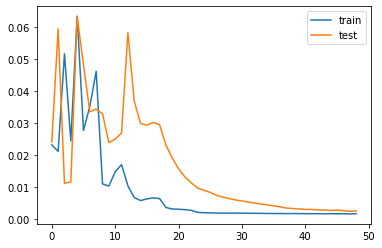

In [3]:
lstm.train_model(epochs = 50, verbose = 2)
lstm.plot_training_history()

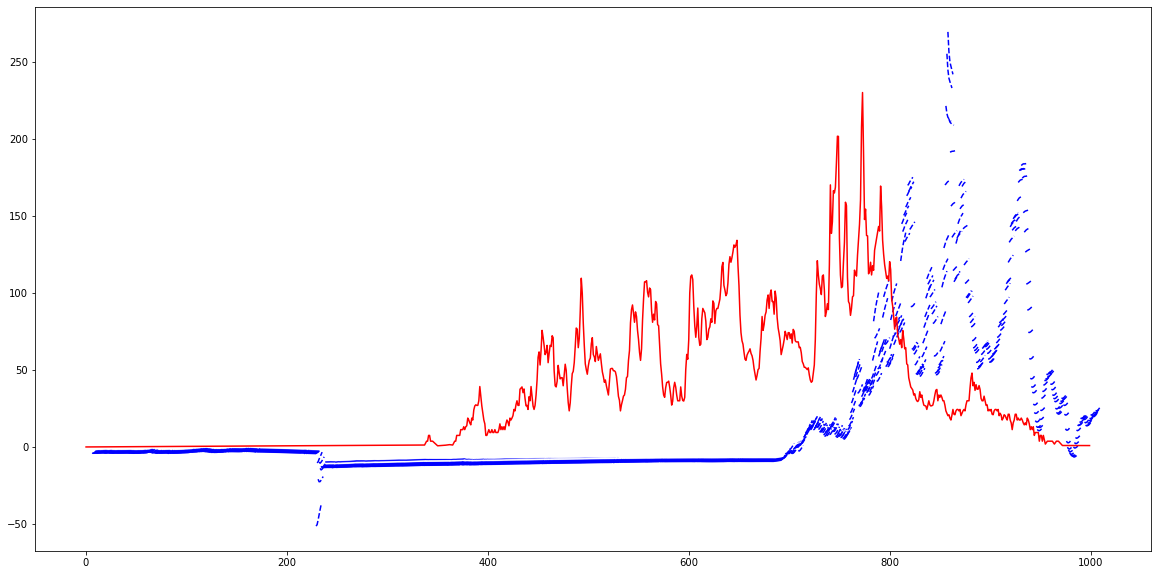

In [4]:
yhat = lstm.predict_on_test_set()
lstm.plot_test_set(yhat, 1000, plot_every=1)


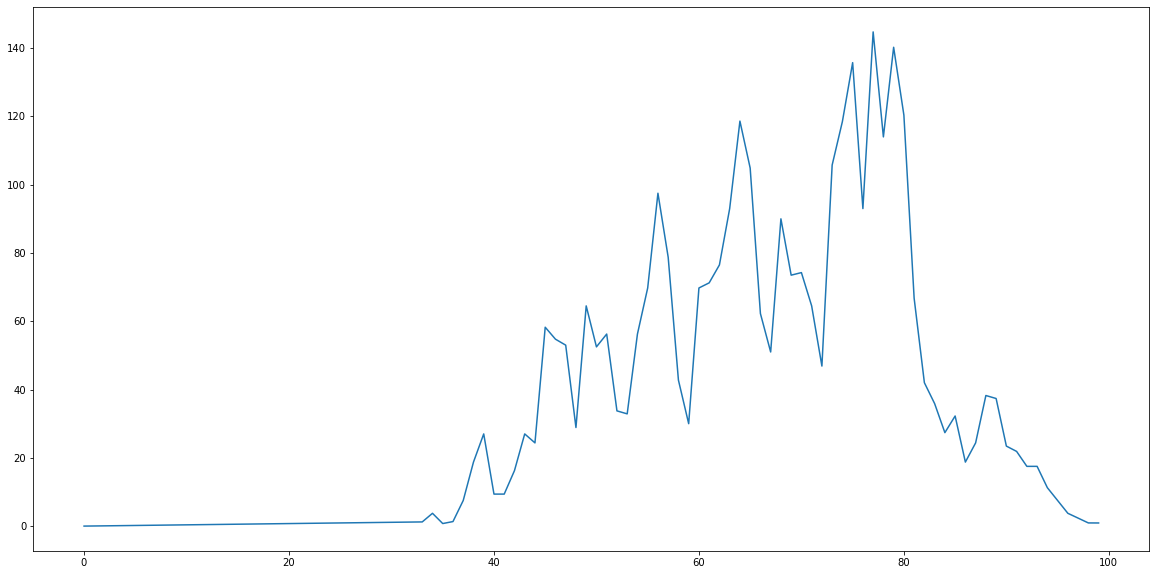

In [909]:
plt.figure(figsize=(20,10))
plt.plot(range(100), data["PV"][:100])

In [898]:
yhat.shape

(8909, 15)